In [1]:
pip install opencv-python scipy pandas    numpy matplotlib seaborn scikit-image tqdm torch    numpy==1.26.4    pillow torchvision


Note: you may need to restart the kernel to use updated packages.


--- Starting Shot Count Proxy Analysis ---
[Metal] Found 16472 files.


Processing Metal: 100%|██████████| 5000/5000 [02:16<00:00, 36.69it/s]


[Via] Found 116405 files.


Processing Via: 100%|██████████| 5000/5000 [02:11<00:00, 37.97it/s]
/var/folders/qf/spzvkx2x32ggwn46dr3vw25m0000gn/T/ipykernel_16681/2458146335.py:87: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="Layer", y="File Size (KB)", ax=axes[0], palette="Set2")
/var/folders/qf/spzvkx2x32ggwn46dr3vw25m0000gn/T/ipykernel_16681/2458146335.py:90: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="Layer", y="Complexity Index", ax=axes[1], palette="Set2")



Collected 10000 samples. Generating plots...


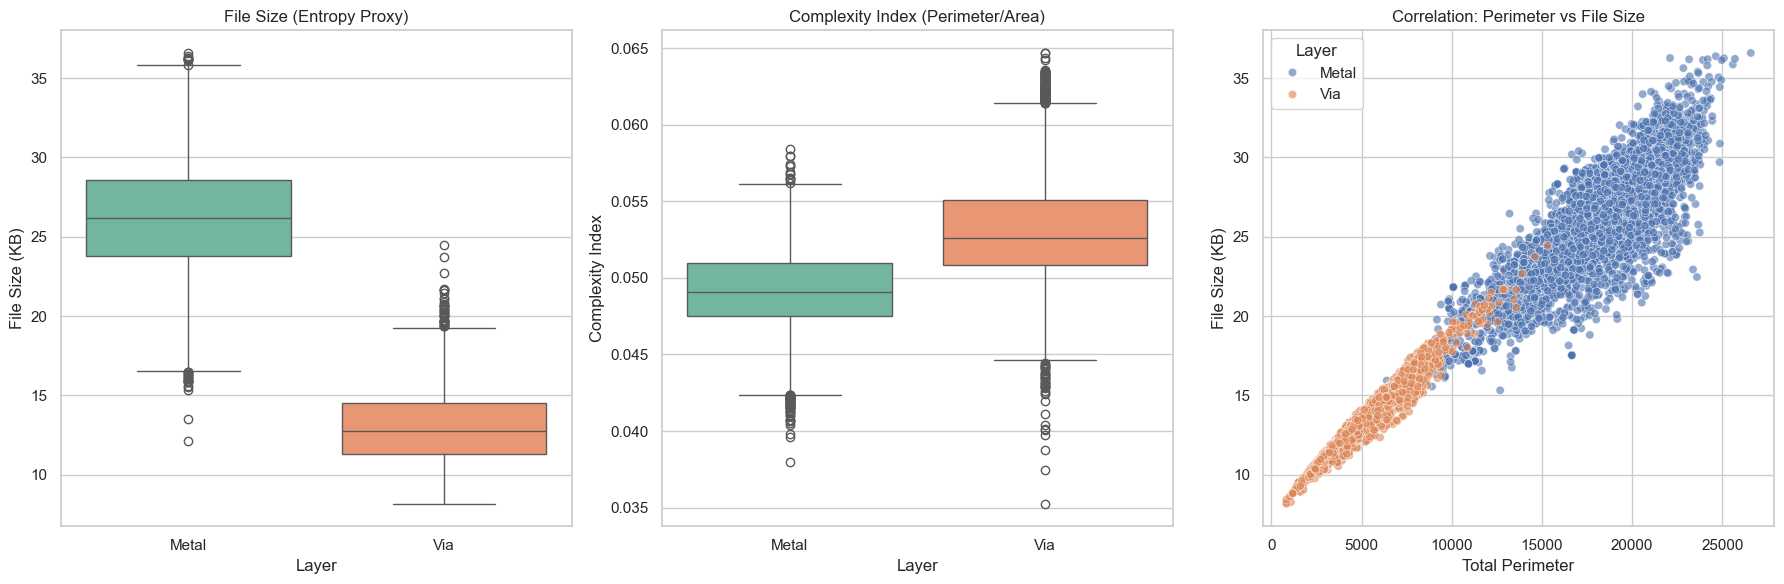

In [4]:
import os
import glob
import cv2
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

def analyze_shot_cost():
    # --- CONFIGURATION: CHECK THIS PATH ---
    # Ensure this points to where you actually extracted the data
    BASE_PATH = "./Datasets/lithodata" 
    
    METAL_PATH = os.path.join(BASE_PATH, "MetalSet", "pixelILT")
    VIA_PATH = os.path.join(BASE_PATH, "ViaSet", "pixelILT")
    
    data = []

    print("--- Starting Shot Count Proxy Analysis ---")
    # print(f"Looking for Metal images in: {os.path.abspath(METAL_PATH)}")
    # print(f"Looking for Via images in:   {os.path.abspath(VIA_PATH)}")

    def process_folder(path, layer_type):
        if not os.path.exists(path):
            print(f"!! WARNING: Folder not found: {path}")
            return

        # Look for png, jpg, jpeg
        files = glob.glob(os.path.join(path, "*.*"))
        # Filter for images only
        files = [f for f in files if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        
        print(f"[{layer_type}] Found {len(files)} files.")
        
        if len(files) == 0:
            return

        for f_path in tqdm(files[:5000], desc=f"Processing {layer_type}"):
            try:
                # Metric 1: File Size (KB)
                file_size_kb = os.path.getsize(f_path) / 1024.0
                
                # Metric 2: Total Perimeter
                img = cv2.imread(f_path, cv2.IMREAD_GRAYSCALE)
                if img is None: continue # Skip bad images
                
                _, thresh = cv2.threshold(img, 127, 255, 0)
                contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
                
                total_perimeter = 0
                total_area = 0
                
                for cnt in contours:
                    total_perimeter += cv2.arcLength(cnt, True)
                    total_area += cv2.contourArea(cnt)
                
                if total_area == 0: continue

                complexity_index = total_perimeter / total_area

                data.append({
                    "Layer": layer_type,
                    "File Size (KB)": file_size_kb,
                    "Total Perimeter": total_perimeter,
                    "Complexity Index": complexity_index
                })
            except Exception as e:
                print(f"Error reading {f_path}: {e}")

    process_folder(METAL_PATH, "Metal")
    process_folder(VIA_PATH, "Via")

    # --- DATAFRAME CREATION ---
    df = pd.DataFrame(data)

    # --- SAFETY CHECK ---
    if df.empty:
        print("\n!!! ERROR: No data was collected. Please check the paths printed above. !!!")
        return

    print(f"\nCollected {len(df)} samples. Generating plots...")

    # --- PLOTTING ---
    sns.set_theme(style="whitegrid")
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    sns.boxplot(data=df, x="Layer", y="File Size (KB)", ax=axes[0], palette="Set2")
    axes[0].set_title("File Size (Entropy Proxy)")

    sns.boxplot(data=df, x="Layer", y="Complexity Index", ax=axes[1], palette="Set2")
    axes[1].set_title("Complexity Index (Perimeter/Area)")

    sns.scatterplot(data=df, x="Total Perimeter", y="File Size (KB)", hue="Layer", alpha=0.6, ax=axes[2])
    axes[2].set_title("Correlation: Perimeter vs File Size")
    
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    analyze_shot_cost()